<a href="https://colab.research.google.com/github/pondels/CSE450/blob/main/module4/Module_4_Nathan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
holdout_df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv')
mini_df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv')
rollCallDates = pd.to_datetime(pd.read_csv('./extra-data/rollcalls.csv')["date"]).drop_duplicates()
holidays = pd.read_csv('./extra-data/holiday-dates-2004-2021.csv')


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#tf.debugging.set_log_device_placement(True)

In [28]:
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
print(device_name)
print('Found GPU at: {}'.format(device_name))


Found GPU at: 


#Explore the data

In [29]:
bikes
bikes.describe()
bikes.info()


,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
0,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13
1,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32
2,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27
3,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10
4,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16632,11/30/12,4,19,0,1,1,0.66,0,7.04,7.0010,18,359
16633,11/30/12,4,20,0,1,1,0.66,0,7.04,7.0010,12,233
16634,11/30/12,4,21,0,1,1,0.75,6,6.10,5.0012,14,169
16635,11/30/12,4,22,0,1,1,0.75,0,6.10,5.9978,18,145


,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,2.482058,11.547875,0.028671,0.684378,1.415580,0.624756,12.750436,15.723008,15.852141,36.471239,154.005770
std,1.085930,6.914199,0.166885,0.464777,0.637298,0.193227,8.168415,9.041349,11.322751,49.995203,151.319818
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-7.060000,-16.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,0.000000,1.000000,0.470000,7.000000,7.980000,5.997800,4.000000,35.000000
50%,2.000000,12.000000,0.000000,1.000000,1.000000,0.620000,13.000000,16.440000,17.000000,17.000000,116.000000
75%,3.000000,18.000000,0.000000,1.000000,2.000000,0.780000,17.000000,23.020000,24.999200,50.000000,220.000000
max,4.000000,23.000000,1.000000,1.000000,4.000000,1.000000,57.000000,39.000000,50.000000,367.000000,886.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dteday        16637 non-null  object 
 1   season        16637 non-null  int64  
 2   hr            16637 non-null  int64  
 3   holiday       16637 non-null  int64  
 4   workingday    16637 non-null  int64  
 5   weathersit    16637 non-null  int64  
 6   hum           16637 non-null  float64
 7   windspeed     16637 non-null  int64  
 8   temp_c        16637 non-null  float64
 9   feels_like_c  16637 non-null  float64
 10  casual        16637 non-null  int64  
 11  registered    16637 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.5+ MB


<AxesSubplot: xlabel='hr', ylabel='registered'>

<AxesSubplot: xlabel='hr', ylabel='registered'>

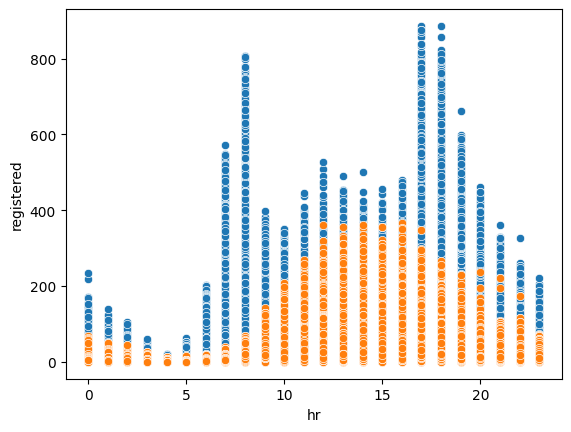

In [30]:
bikes["total"] = bikes['casual'] + bikes['registered']
sns.scatterplot(data= bikes, x = "hr", y = "registered")
sns.scatterplot(data= bikes, x = "hr", y = "casual")
#sns.barplot(data= bikes, x = bikes.index, y = "total")

# sns.pairplot(bikes)

#over time registered casual total

#Visualize data

In [31]:
for column in bikes[["season", "hr", "holiday", "workingday", "weathersit"]].columns:
  print(bikes[column].value_counts())



3    4496
2    4409
1    3980
4    3752
Name: season, dtype: int64
17    699
16    699
13    698
15    698
14    698
12    697
22    697
21    697
20    697
19    697
18    697
23    697
11    696
10    696
9     696
8     696
7     696
0     695
6     694
1     693
5     686
2     684
4     667
3     667
Name: hr, dtype: int64
0    16160
1      477
Name: holiday, dtype: int64
1    11386
0     5251
Name: workingday, dtype: int64
1    11078
2     4207
3     1349
4        3
Name: weathersit, dtype: int64


#preprocess/feature engineering? 
onehot



In [32]:
#cyclical https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
def makeItCycle(df, column, period):
  df[column+'sin'] = np.sin(2 * np.pi * df[column]/period)
  df[column+'cos'] = np.cos(2 * np.pi * df[column]/period)
  return df.drop(columns=[column])
def preprocess(X, scaler, resetScaler = False):
  proc = pd.DataFrame(X,copy = True)
  datetimes = pd.to_datetime(X.dteday)
  proc["dayOfWeek"] = datetimes.dt.weekday
  proc['day'] = datetimes.dt.day
  proc['month'] = datetimes.dt.month
  proc['year'] = datetimes.dt.year
  proc['date'] = (datetimes - pd.datetime(1970,1,1)).dt.total_seconds()
  proc['rushHour'] = pd.Series(X['hr'].isin([7,8,17,18])).astype(int)
  proc['congress_day'] = datetimes.dt.date.isin(rollCallDates.dt.date).astype(int)
  proc['significant-holiday'] = (datetimes.dt.date.isin(pd.to_datetime(holidays['Date']).dt.date)).astype(int)
  proc['winter-holiday'] = (proc['significant-holiday'] == proc['month'].isin([1,2,11,12])).astype(int)
  proc = proc.drop(columns = ["dteday"])
  print(proc.info())
  proc = makeItCycle(proc, 'day', 31)
  proc = makeItCycle(proc, 'month', 12)
  proc = makeItCycle(proc, 'hr', 24)
  proc = makeItCycle(proc, 'season', 4)
  if (resetScaler):
    scaler.fit(proc)
  proc = pd.DataFrame(scaler.transform(proc))es.dt.date.isin(rollCallDates.dt.date).astype(int)
  # proc['significant-holiday'] = 
  return proc, scaler

tempDf, tempScaler  = preprocess(bikes, MinMaxScaler(), True)

# temp['dist-to-holiday'] =

# sns.histplot(temp, x = "dteday", hue = "significant-holiday", y = "total")
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=45)
# subset = temp[temp['significant-holiday'] == 1]
# sns.scatterplot(subset, x='dteday', y='total', hue = 'winter-holiday')
tempDf.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               16637 non-null  int64  
 1   hr                   16637 non-null  int64  
 2   holiday              16637 non-null  int64  
 3   workingday           16637 non-null  int64  
 4   weathersit           16637 non-null  int64  
 5   hum                  16637 non-null  float64
 6   windspeed            16637 non-null  int64  
 7   temp_c               16637 non-null  float64
 8   feels_like_c         16637 non-null  float64
 9   casual               16637 non-null  int64  
 10  registered           16637 non-null  int64  
 11  total                16637 non-null  int64  
 12  dayOfWeek            16637 non-null  int64  
 13  day                  16637 non-null  int64  
 14  month                16637 non-null  int64  
 15  year                 16637 non-null 

C:\Users\spott\AppData\Local\Temp\ipykernel_19584\2442830541.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  proc['date'] = (datetimes - pd.datetime(1970,1,1)).dt.total_seconds()


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,...,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,0.684378,0.138527,0.624756,0.223692,0.494638,0.482608,0.099377,0.173821,0.194136,...,0.048927,0.702470,0.501895,0.488017,0.497110,0.474326,0.497692,0.498289,0.484492,0.480255
std,0.166885,0.464777,0.212433,0.193227,0.143306,0.196295,0.171557,0.136227,0.170790,0.186503,...,0.215722,0.457185,0.357423,0.350863,0.360497,0.345527,0.353406,0.353711,0.356558,0.349644
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.470000,0.122807,0.326531,0.333300,0.010899,0.039503,0.040984,...,0.000000,0.000000,0.137138,0.118359,0.066987,0.066987,0.146447,0.146447,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.620000,0.228070,0.510204,0.500000,0.046322,0.130926,0.145492,...,0.000000,1.000000,0.500000,0.473324,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,0.000000,1.000000,0.333333,0.780000,0.298246,0.653061,0.621200,0.136240,0.248307,0.287910,...,0.000000,1.000000,0.862862,0.844083,0.933013,0.750000,0.853553,0.853553,0.500000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
# procBikes = pd.DataFrame(bikes)
# procBikes['total'] = bikes['casual'] + bikes['registered']
# datetimes = pd.to_datetime(bikes.dteday)
# procBikes["dayOfWeek"] = datetimes.dt.weekday
# procBikes['day'] = datetimes.dt.day
# procBikes['month'] = datetimes.dt.month
# procBikes['year'] = datetimes.dt.year
# procBikes['date'] = (datetimes - pd.datetime(1970,1,1)).dt.total_seconds()
# procBikes['rushHour'] = pd.Series(bikes['hr'].isin([7,8,17,18])).astype(int)
# procBikes
# procBikes = bikes.drop(columns = ["dteday"])
# #millis?


# # procBikes = pd.get_dummies(data = bikes, columns = ["hr"])
# procBikes
# #weekday
# #cyclical https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
# def makeItCycle(df, column, period):
#   df[column+'Sin'] = np.sin(2 * np.pi * df[column]/period)
#   df[column+'Cos'] = np.cos(2 * np.pi * df[column]/period)
#   return df.drop(columns=[column])



# procBikes = makeItCycle(procBikes, 'day', 31)
# procBikes = makeItCycle(procBikes, 'month', 12)
# procBikes = makeItCycle(procBikes, 'hr', 24)
# procBikes = makeItCycle(procBikes, 'season', 4)

In [34]:

X = bikes.drop(columns=["registered", "casual", "total"])



X, scaler = preprocess(X, scaler=MinMaxScaler(), resetScaler= True)
y = bikes["total"]



def mySplit(X,y,kth):
  X_test = X.iloc[::kth, :]
  y_test = y.iloc[::kth]
  X_train = X[~X.index.isin(X_test.index)]
  y_train = y[~y.index.isin(y_test.index)]
  return X_train, y_train,  X_test, y_test
X_train, y_train, X_val, y_val = mySplit(X, y, 11)



# mySplit(X, y, 9)


#X[~trainIndex]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               16637 non-null  int64  
 1   hr                   16637 non-null  int64  
 2   holiday              16637 non-null  int64  
 3   workingday           16637 non-null  int64  
 4   weathersit           16637 non-null  int64  
 5   hum                  16637 non-null  float64
 6   windspeed            16637 non-null  int64  
 7   temp_c               16637 non-null  float64
 8   feels_like_c         16637 non-null  float64
 9   dayOfWeek            16637 non-null  int64  
 10  day                  16637 non-null  int64  
 11  month                16637 non-null  int64  
 12  year                 16637 non-null  int64  
 13  date                 16637 non-null  float64
 14  rushHour             16637 non-null  int32  
 15  congress_day         16637 non-null 

C:\Users\spott\AppData\Local\Temp\ipykernel_19584\2442830541.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  proc['date'] = (datetimes - pd.datetime(1970,1,1)).dt.total_seconds()


#Create model

In [35]:
#run multiple times with different random states
tf.random.set_seed(42)

def create_model(initializer='uniform', activation='selu', optimizer='adam', dropoutRate = 0.1, numExtraLayers = 10):
    model = Sequential()
    if (activation == 'leakyRelu'): activation = LeakyReLU()
    model.add(Dense(128, input_dim=len(X_train.columns), activation=activation))
    model.add(Dropout(dropoutRate))
    model.add(Dense(256, activation=activation))
    model.add(Dropout(dropoutRate))
    for i in range(0,numExtraLayers):
        model.add(Dense(128, activation=activation))
    model.add(Dense(1, activation=activation))
    opt = keras.optimizers.Adam()
    model.compile(loss="msle", optimizer=opt, metrics=['mse'])
    return model

model = create_model(numExtraLayers=3)

# model = keras.models.load_model('nathan-model')



In [36]:
param_grid = {
    # 'initializer': ['glorot_uniform'],
    # 'optimizer': ['adam'],
    # 'numExtraLayers': [0],
    # 'dropoutRate' : [0.1],
    # 'batch_size': [24],
    'epochs': [90, 120, 150],
}


In [37]:
# cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
# #grid_search = GridSearchCV(
#     estimator=KerasRegressor(create_model),
#     param_grid=param_grid,
#     cv=cv,
#     n_jobs = -1,
#     verbose = 0
# )
# todo fix
# early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=30)
#reslts = grid_search.fit(X, y, batch_size = 24)
#grid_search.best_params_

# reslts = grid_search.fit(X, y, verbose=1, callbacks=[early_stop])
#GPU: 3 min 55
#cpu: 1:50#
# num jobs -1 cpu: 0:32.5
#best {'activation': 'selu', 'epochs': 60}
# {'activation': 'selu', 'batch_size': 24, 'epochs': 90}


In [38]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
#tf.device('/cpu:0')
#tf.device('/device:GPU:0')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10000, batch_size=24, callbacks=[early_stop],shuffle=False)
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=24, callbacks=[early_stop],shuffle=False)
# history = model.fit(X_train, y_train, epochs=2000, batch_size=24,shuffle=False)
# history = model.fit(X_train, y_train, epochs=2000, verbose=0, validation_split = .2, batch_size=25,
#                     callbacks=[early_stop])

# hist = pd.DataFrame(history.history)

try:
    hist.drop(columns='index', inplace=True)
    hist = pd.concat([hist, pd.DataFrame(history.history)], axis = 0, ignore_index=True)


except NameError:
    hist = pd.DataFrame(history.history)

hist = hist.reset_index()

Epoch 1/1000
631/631 [==============================] - 3s 3ms/step - loss: 0.9355 - mse: 14922.4668 - val_loss: 0.6823 - val_mse: 15917.9404
Epoch 2/1000
631/631 [==============================] - 2s 3ms/step - loss: 0.5794 - mse: 12444.5615 - val_loss: 0.7411 - val_mse: 18326.7188
Epoch 3/1000
631/631 [==============================] - 2s 3ms/step - loss: 0.5279 - mse: 11829.9766 - val_loss: 0.6470 - val_mse: 16058.9844
Epoch 4/1000
631/631 [==============================] - 2s 3ms/step - loss: 0.3885 - mse: 7969.8452 - val_loss: 0.8821 - val_mse: 17283.3438
Epoch 5/1000
631/631 [==============================] - 2s 3ms/step - loss: 0.3853 - mse: 8318.0811 - val_loss: 0.5699 - val_mse: 12616.5830
Epoch 6/1000
631/631 [==============================] - 2s 3ms/step - loss: 0.2412 - mse: 5435.9170 - val_loss: 0.4304 - val_mse: 12046.6289
Epoch 7/1000
631/631 [==============================] - 2s 3ms/step - loss: 0.2184 - mse: 4878.0488 - val_loss: 0.4356 - val_mse: 11789.2900
Epoch 8/10

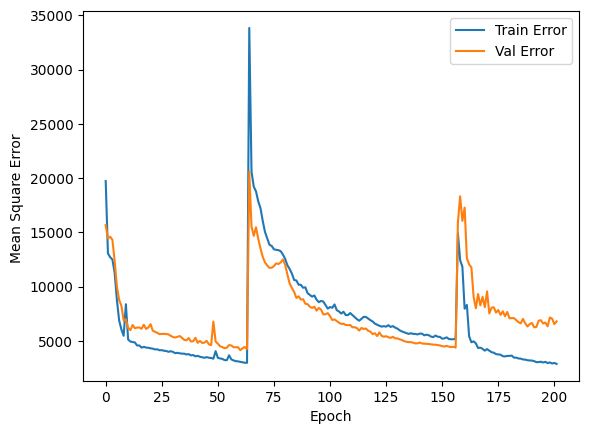

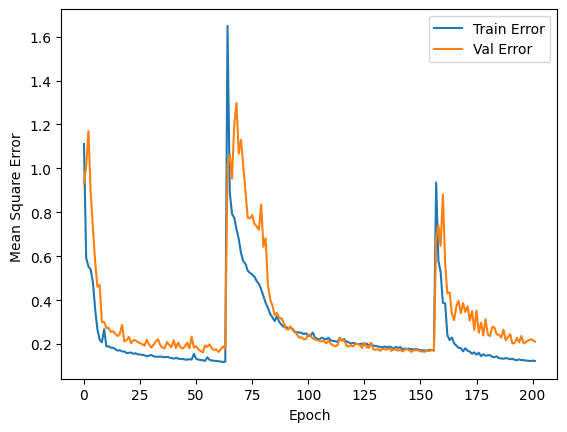

In [39]:
def plot_history(error = 'mse'):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error ')
    # plt.plot(hist['index'], hist['loss'], label='Loss')
    plt.plot(hist['index'], hist[error], label='Train Error')
    plt.plot(hist['index'], hist['val_'+ error], label = 'Val Error')
    plt.legend()
    # plt.xlim([300,450])
    # plt.ylim([0,.18])

plot_history()
plot_history(error='loss')


selu baseline epoch 194  
0.0031 - val_loss: 0.0079 - val_mse: 0.0079


relu epoch 80 loss: 0.0024 - mse: 0.0024 - val_loss: 0.0093 - val_mse: 0.0093

epoch 68 
541/541 [==============================] - 2s 4ms/step - loss: 1954.0997 - mse: 1954.0997 - val_loss: 7660.5137 - val_mse: 7660.5137



In [40]:
predictions = np.round(model.predict(X_val), 0)
len(predictions)
print("rmse ")
mean_squared_error(y_val, predictions, squared=False)
print("r2 ")
r2_score(y_val, predictions)

48/48 [==============================] - 0s 1ms/step


1513

rmse 


82.47760416238751

r2 


0.7945617904719006

In [41]:
def predAndCsv(df, filename): 
    procDf, deleteme = preprocess(pd.DataFrame(data = df, copy=True), scaler=scaler)
    predictions = np.round(model.predict(procDf), 0)
    pd.DataFrame(predictions).clip(lower=0).to_csv(filename, index=False, header= ["predictions"])
    return predictions
# debug_df = mini_df
# debug_df["predictions"] = predAndCsv(mini_df, "nathan-mini-predictions.csv")
predAndCsv(holdout_df, "nathan-holdout-predictions.csv")
predAndCsv(mini_df, "team8-module4-predictions.csv")
# pd.DataFrame(debug_df).to_csv("debug2.csv", index=False)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               742 non-null    int64  
 1   hr                   742 non-null    int64  
 2   holiday              742 non-null    int64  
 3   workingday           742 non-null    int64  
 4   weathersit           742 non-null    int64  
 5   hum                  742 non-null    float64
 6   windspeed            742 non-null    int64  
 7   temp_c               742 non-null    float64
 8   feels_like_c         742 non-null    float64
 9   dayOfWeek            742 non-null    int64  
 10  day                  742 non-null    int64  
 11  month                742 non-null    int64  
 12  year                 742 non-null    int64  
 13  date                 742 non-null    float64
 14  rushHour             742 non-null    int32  
 15  congress_day         742 non-null    int

C:\Users\spott\AppData\Local\Temp\ipykernel_19584\2442830541.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  proc['date'] = (datetimes - pd.datetime(1970,1,1)).dt.total_seconds()


array([[ 59.],
       [ 48.],
       [ 33.],
       [ 11.],
       [  6.],
       [  5.],
       [ 11.],
       [ 27.],
       [ 65.],
       [114.],
       [154.],
       [226.],
       [240.],
       [288.],
       [299.],
       [328.],
       [290.],
       [181.],
       [166.],
       [127.],
       [111.],
       [ 71.],
       [ 60.],
       [ 62.],
       [ 52.],
       [ 48.],
       [ 38.],
       [ 13.],
       [  6.],
       [  5.],
       [ 10.],
       [ 25.],
       [ 62.],
       [118.],
       [199.],
       [220.],
       [250.],
       [333.],
       [359.],
       [366.],
       [306.],
       [132.],
       [193.],
       [134.],
       [110.],
       [ 86.],
       [ 74.],
       [ 68.],
       [ 21.],
       [ 11.],
       [  6.],
       [  5.],
       [  6.],
       [ 33.],
       [126.],
       [373.],
       [550.],
       [258.],
       [163.],
       [192.],
       [225.],
       [244.],
       [229.],
       [220.],
       [293.],
       [615.],
       [58

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   season               35 non-null     int64  
 1   hr                   35 non-null     int64  
 2   holiday              35 non-null     int64  
 3   workingday           35 non-null     int64  
 4   weathersit           35 non-null     int64  
 5   hum                  35 non-null     float64
 6   windspeed            35 non-null     int64  
 7   temp_c               35 non-null     float64
 8   feels_like_c         35 non-null     float64
 9   dayOfWeek            35 non-null     int64  
 10  day                  35 non-null     int64  
 11  month                35 non-null     int64  
 12  year                 35 non-null     int64  
 13  date                 35 non-null     float64
 14  rushHour             35 non-null     int32  
 15  congress_day         35 non-null     int32

C:\Users\spott\AppData\Local\Temp\ipykernel_19584\2442830541.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  proc['date'] = (datetimes - pd.datetime(1970,1,1)).dt.total_seconds()


2/2 [==============================] - 0s 2ms/step


array([[ 59.],
       [ 48.],
       [ 33.],
       [ 11.],
       [  6.],
       [  5.],
       [ 11.],
       [ 27.],
       [ 65.],
       [114.],
       [154.],
       [226.],
       [240.],
       [288.],
       [299.],
       [328.],
       [290.],
       [181.],
       [166.],
       [127.],
       [111.],
       [ 71.],
       [ 60.],
       [ 62.],
       [ 52.],
       [ 48.],
       [ 38.],
       [ 13.],
       [  6.],
       [  5.],
       [ 10.],
       [ 25.],
       [ 62.],
       [118.],
       [199.]], dtype=float32)

#refine 

grid search

In [42]:

# model.save('nathan-model')

In [43]:
#grid search